    "all_wheels_on_track": Boolean,        # flag to indicate if the agent is on the track
    "x": float,                            # agent's x-coordinate in meters
    "y": float,                            # agent's y-coordinate in meters
    "closest_objects": [int, int],         # zero-based indices of the two closest objects to the agent's current position of (x, y).
    "closest_waypoints": [int, int],       # indices of the two nearest waypoints.
    "distance_from_center": float,         # distance in meters from the track center 
    "is_crashed": Boolean,                 # Boolean flag to indicate whether the agent has crashed.
    "is_left_of_center": Boolean,          # Flag to indicate if the agent is on the left side to the track center or not. 
    "is_offtrack": Boolean,                # Boolean flag to indicate whether the agent has gone off track.
    "is_reversed": Boolean,                # flag to indicate if the agent is driving clockwise (True) or counter clockwise (False).
    "heading": float,                      # agent's yaw in degrees
    "objects_distance": [float, ],         # list of the objects' distances in meters between 0 and track_length in relation to the starting line.
    "objects_heading": [float, ],          # list of the objects' headings in degrees between -180 and 180.
    "objects_left_of_center": [Boolean, ], # list of Boolean flags indicating whether elements' objects are left of the center (True) or not (False).
    "objects_location": [(float, float),], # list of object locations [(x,y), ...].
    "objects_speed": [float, ],            # list of the objects' speeds in meters per second.
    "progress": float,                     # percentage of track completed
    "speed": float,                        # agent's speed in meters per second (m/s)
    "steering_angle": float,               # agent's steering angle in degrees
    "steps": int,                          # number steps completed
    "track_length": float,                 # track length in meters.
    "track_width": float,                  # width of the track
    "waypoints": [(float, float), ]        # list of (x,y) as milestones along the track center

In [1]:
import matplotlib.pyplot as plt
import numpy as np
# 2022_may_open_ccw - Ross Raceway Counter-Clockwise

Matplotlib is building the font cache; this may take a moment.


In [2]:
class Ref:
    history = {}


def reward_function(params):
    '''
    Reward for making more progress, for example by cutting corners.
    For this, the term effective speed has been devised which is computed
    based on the progress percentage and the track length. The effective
    speed is the speed that it would have been expected to travel at to have
    progressed that far around the track.

    The progress reward is then computed as the effective speed, but
    don't reward if any wheels go off-track at any time during
    the previous 20 steps.

    '''

    const_e = 2.718281828

    # Read input parameters
    progress = params['progress']  # percentage
    nsteps = int(params['steps'])  # 1/10 second
    track_length = params['track_length']  # metres
    all_wheels_on_track = params['all_wheels_on_track']

    # Setup history
    history = Ref.history
    if nsteps <= 1:
        history.clear()
    history[nsteps] = {
        'progress': progress,
        'all_wheels_on_track': all_wheels_on_track,
    }

    # Overall scaling
    scaling_wt = 2.0

    # Raise progress to this exponent
    progress_power = 2.0

    # Timestep assumed for progress computations
    steps_per_sec = 15

    # progress reward is effective speed
    # where effective speed is computed by converting the
    # progress into a metres per second value based on the track length
    # initialize a default progress reward of 1.0
    progress_reward = 1.0  # default
    steps_in_history = [i for i in range(nsteps - 20, nsteps)
                        if i in history]
    if any(not history[i]['all_wheels_on_track'] for i in steps_in_history):
        # went off the track
        progress_reward = 0.001
    else:
        if len(steps_in_history) > 0:
            i = steps_in_history[0]
            effective_speed = (
                progress - history[i]['progress']
            ) * track_length / 100 * steps_per_sec / (nsteps - i)
            # normalize so reward is 1.0 for speed of 2.8 m/s
            progress_reward = effective_speed / 2.8
    # never negative
    progress_reward = max(0.001, progress_reward)

    # Non-linear so more progress is rewarded
    return scaling_wt \
        * progress_reward ** progress_power


In [3]:
def plot_param(xmin, xmax, const_params, param_to_plot, reward_func):
    '''
    Plot output of the reward function by varying a single input parameter.
    
    xmin, xmax: range of input
    const_params: dict of values defining params to keep constant
    param_to_plot: name of parameter to plot
    reward_func: reward function matching standard deepracer signature
    '''
    x = list(np.linspace(xmin, xmax, num=40, dtype='O'))
    y = [
        reward_function({
            **const_params,
            param_to_plot: x_val
        })
        for x_val in x
    ]
    plt.figure()
    plt.plot(x, y, 'o')
    plt.grid()
    plt.show()

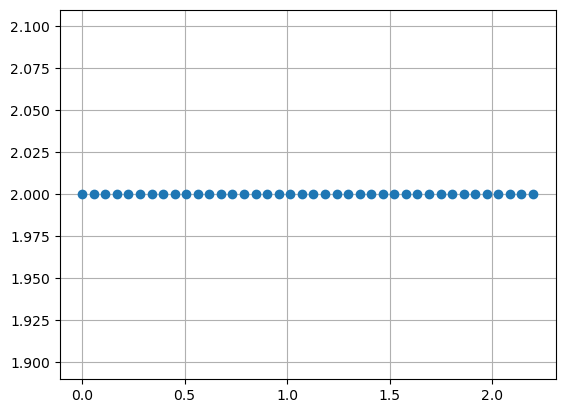

In [4]:
plot_param(
    0,
    2.2,
    const_params={'track_width': 4.0, 'progress': 22.4, 'steps': 60,
                  'track_length': 50, 'all_wheels_on_track': True,
                  'speed': 4.0},
    param_to_plot='distance_from_center',
    reward_func=reward_function
)

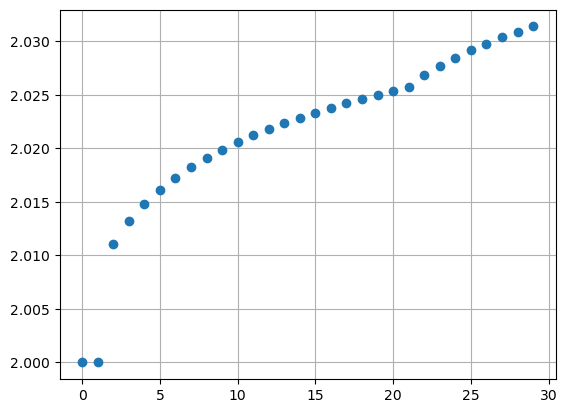

In [9]:
const_params={'track_width': 4.0, 'distance_from_center': 0.1,
              'track_length': 50, 'all_wheels_on_track': True,
              'speed': 2.8}
steps = list(range(30))
y = [
    reward_function({
        **const_params,
        'progress': s**1.002 * 2.8/15 * 100/50,
        'steps': s,
    })
    for s in steps
]
plt.figure()
plt.plot(steps, y, 'o')
plt.grid()
plt.show()

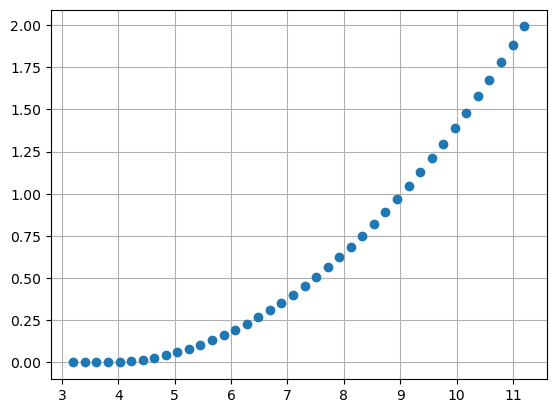

In [10]:
plot_param(
    3.2,
    11.2,
    const_params={'track_width': 4.0, 'distance_from_center': 0.1,
                  'track_length': 50, 'all_wheels_on_track': True,
                  'speed': 2.0, 'steps': 30},
    param_to_plot='progress',
    reward_func=reward_function
)

In [7]:
# make it go off track
for i in range(20, 22):
    reward_function({
        'track_width': 4.0, 'distance_from_center': 0.1,
        'track_length': 50, 'all_wheels_on_track': False,
        'speed': 2.0, 'steps': i, 'progress': 3
    })